# EDA

## data1 (Regression_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/Regression_data.csv')
df.info()
df.head()
print(f'\n 중복항 존재여부 : {df.duplicated().any()}\n')
print(df.Sex.value_counts())
# Sex를 제외하곤 전부 수치형데이터 => catboost 고려 x
# Sex 컬럼의 카디널리티 3, 분포는 고른편
# 결측치 없음. 중복 없음
# row 4177개로 비교적 적음. => lightGBM 고려 x
# => 우선적으로 xgboost와 딥러닝중 선택해야할듯?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB

 중복항 존재여부 : False

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


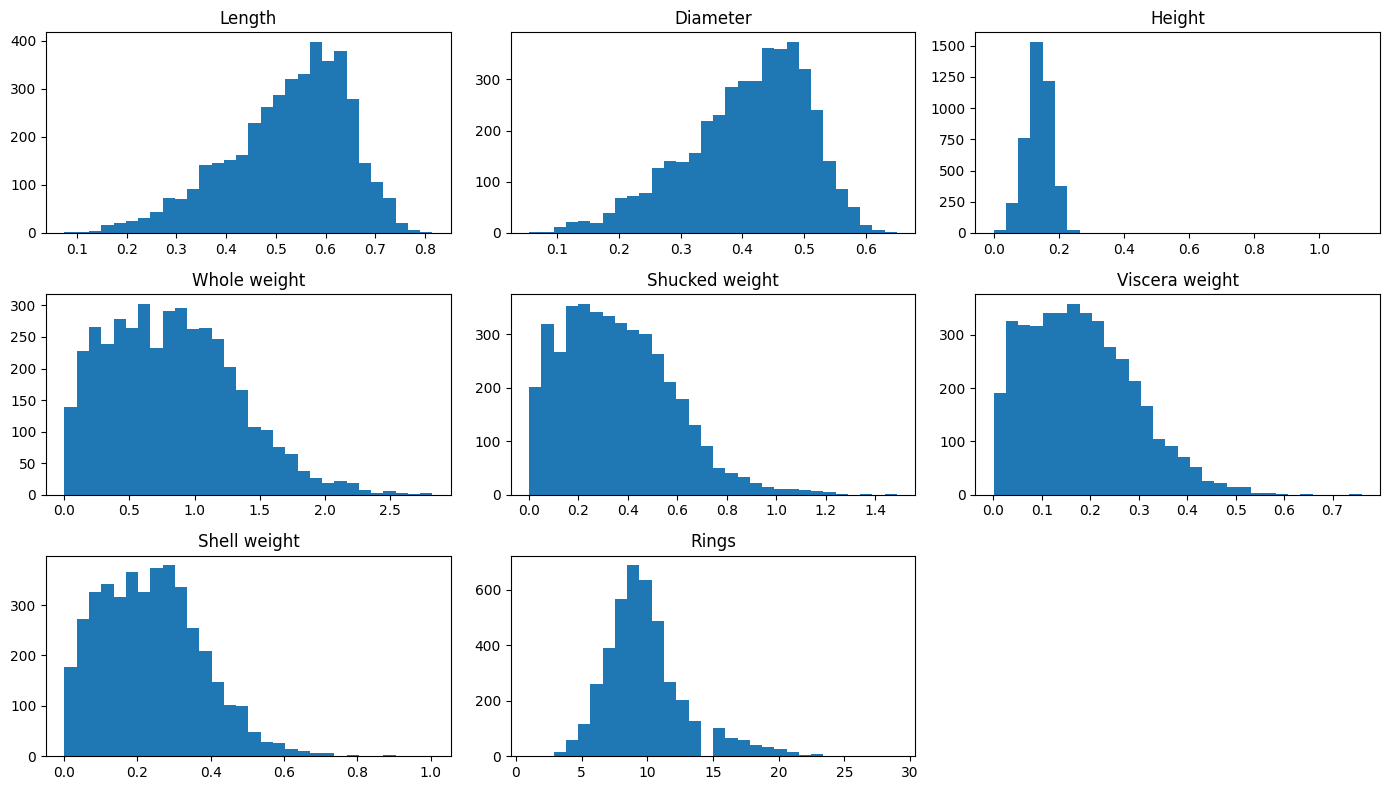

In [2]:
def hist(column):
    plt.hist(column, bins=50)
    plt.title(f'{column.name} hist')
    plt.show()

df.select_dtypes(include=[float, int]).hist(bins=30, figsize=(14,8), grid=False)
plt.tight_layout()
plt.show()
# 수치형데이터 분포 확인
# right skewed : column 4, 5, 6, 7
# left skewed : column 1, 2
# outlier 존재 : column 3
# 타겟 데이터는 약한 right skewed

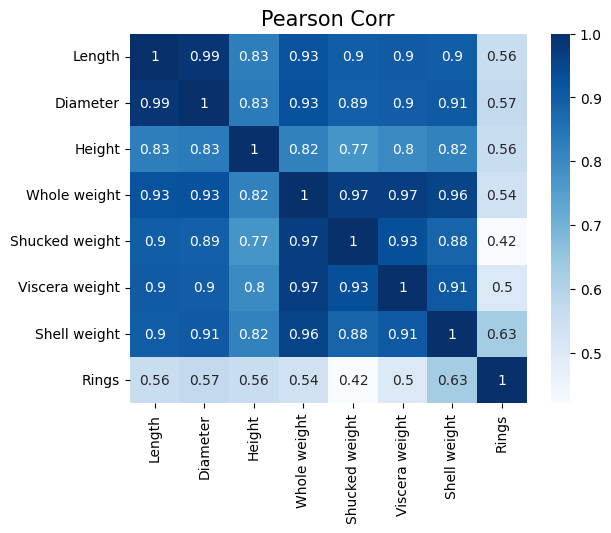

In [3]:
# column3 (Height) 아웃라이어 : 1.130, 0.515
df.Height.sort_values(ascending=False)[:5]

# 상관계수 확인
sns.heatmap(df.iloc[:,1:].corr().abs(), annot=True, cmap='Blues')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# 전반적으로 컬럼들의 상관계수가 높다.
# (Length, Diameter) (Whole wieght, Shucked weight)가 상관계수 높음
# => 차원축소 고려?

(여기서부터 내용 추가)

In [15]:
print(df.describe())

print(df[df['Height']==0])

# Height 컬럼에 최소값이 0인 것 2개 확인 -> 삭제 필요

            Length     Diameter       Height  Whole weight  Shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.

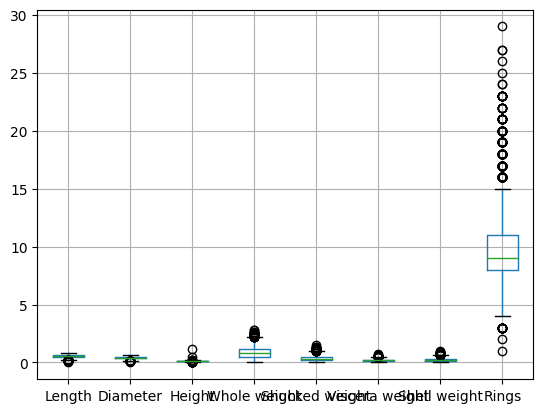

<Figure size 2000x1500 with 0 Axes>

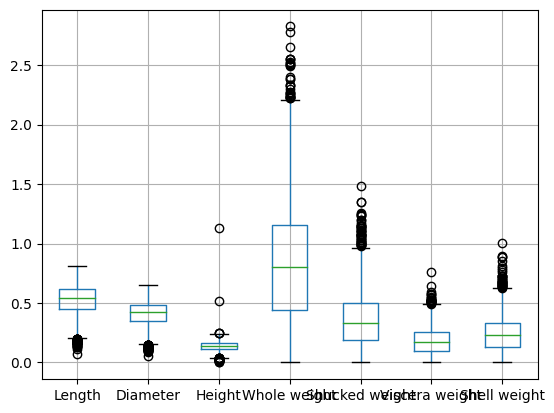

<Figure size 2000x1500 with 0 Axes>

In [16]:
# 박스 플롯
# 모든 데이터

df.boxplot()
plt.figure(figsize=(20,15))
plt.show()


# 종속변수 제외

boxplot_data = df.drop('Rings', axis=1)

boxplot_data.boxplot()
plt.figure(figsize=(20,15))
plt.show()

In [ ]:
#Height에 이상치 : 0인 것, 1.13인 것
data[data['Height']==0]

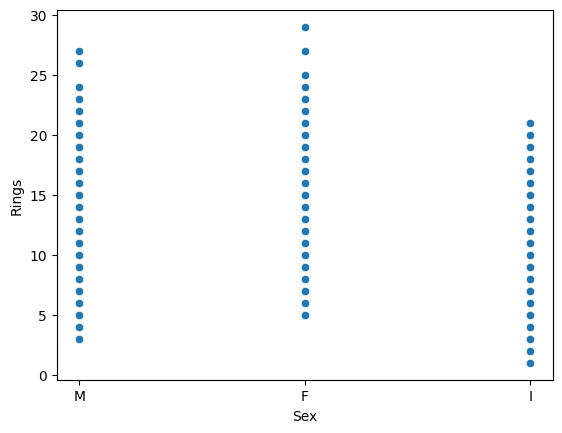

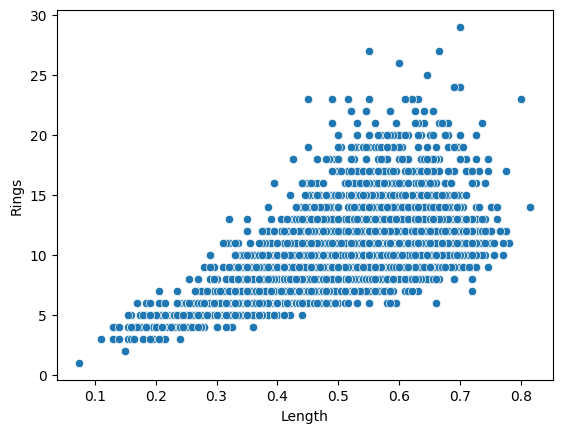

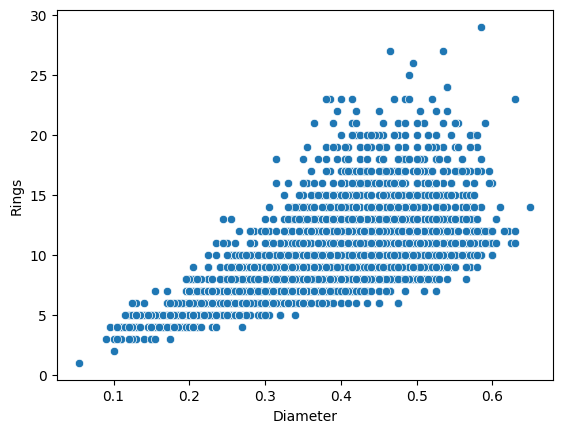

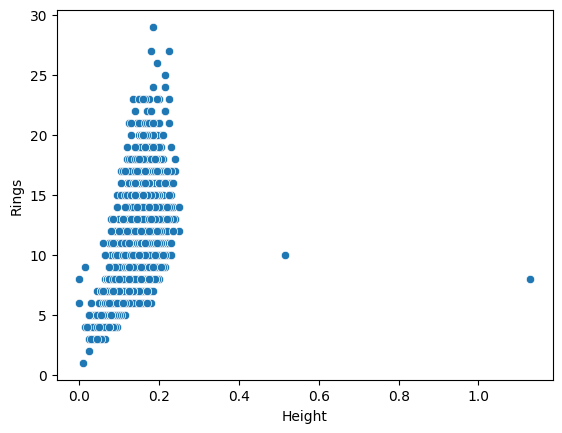

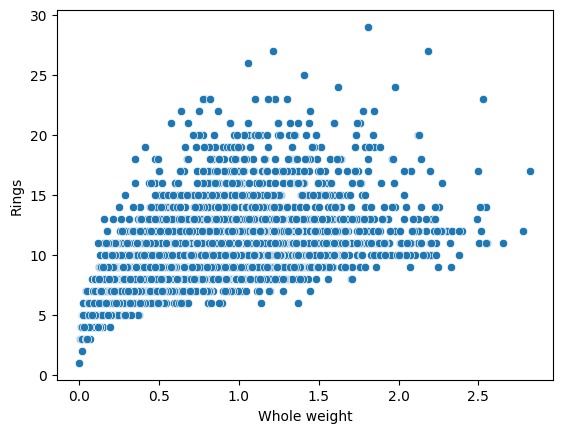

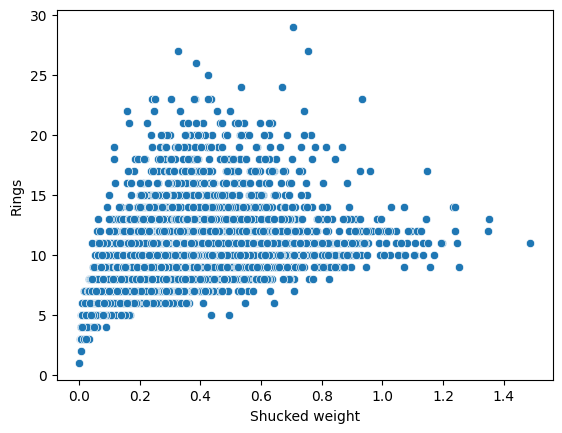

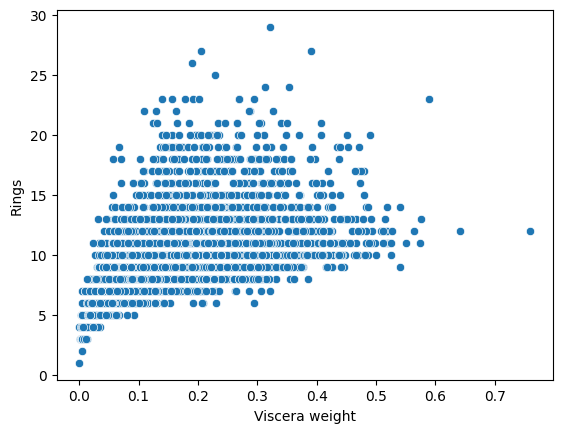

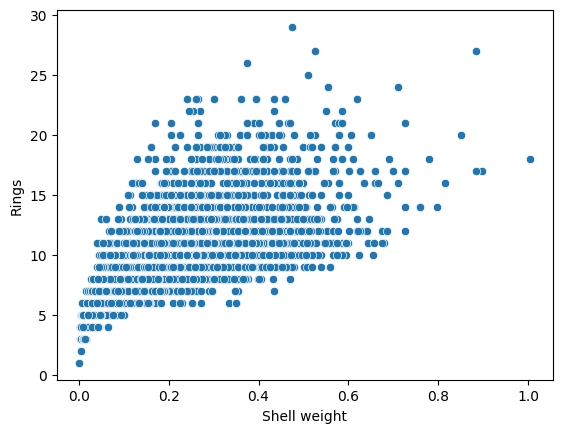

In [4]:
# 산점도

X = df.drop('Rings', axis=1)
y = df["Rings"]

for column in X.columns:
    fig, ax = plt.subplots()
    sns.scatterplot(x=X[column], y=y)
    plt.show()

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

# VIF 확인
# Height 컬럼 빼고 모두 극심한 다중공선성 수치가 나타남

# 'Sex' feature 원핫인코딩
encoder = OneHotEncoder(sparse=False) 
sex_encoded = encoder.fit_transform(df[['Sex']])

sex_encoded_df = pd.DataFrame(sex_encoded, columns=['M','F','I'])

# 'Sex' 컬럼을 인코딩된 컬럼으로 교체
X = df.drop("Sex", axis=1)
X = pd.concat([X, sex_encoded_df], axis=1)
encoded_df = X.drop("Rings", axis=1)

# VIF를 계산하는 함수 정의
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(encoded_df)

print(vif_result)

/Users/nayeon/miniforge3/envs/project1/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


          Feature         VIF
0          Length   40.945763
1        Diameter   42.379841
2          Height    3.581369
3    Whole weight  109.768710
4  Shucked weight   28.550546
5  Viscera weight   17.445012
6    Shell weight   21.263272
7               M   23.079561
8               F   19.854572
9               I   25.751173


## data2 (Binary_classification_data)

In [5]:
df2 = pd.read_csv('data/binary_classification_data.csv')
df2.info()
print(f'\n 중복항 존재여부 : {df2.duplicated().any()}\n')
print('target class 비율')
df2.target_class.value_counts(normalize=True)

# row 17898개, 범주형 없음, 중복, 결측없음
# => catboost, LightGBM 고려 x
# target의 비율이 약 9:1로 클래스불균형 매우 심함
# => 이상탐지 모델 혹은 샘플링기법 사용 고려

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB

 중복항 

target_class
0    0.908426
1    0.091574
Name: proportion, dtype: float64

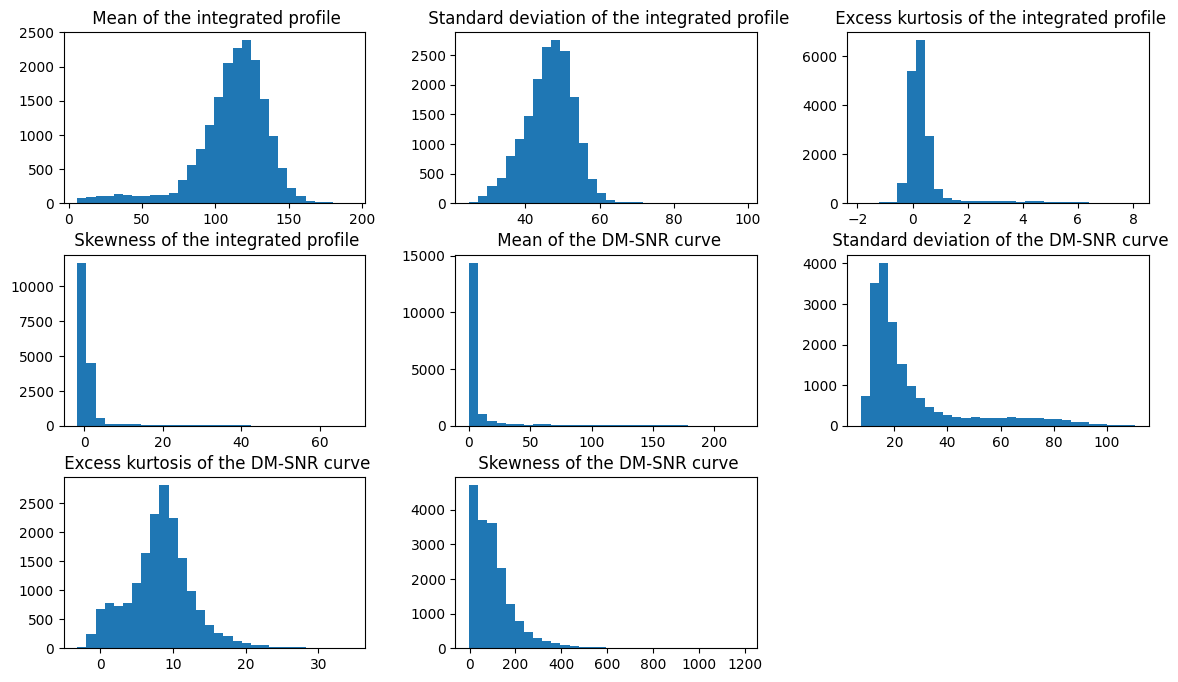

In [6]:
# 데이터 분포 확인
df2.iloc[:,:-1].hist(bins=30, figsize=(14,8), grid=False)
plt.show()

# right skewed : column 3, 4, 5, 6, 7, 8
# left skewed : column 1
# outlier 존재 : column 2, 3, 4, 5, 8
# 아웃라이어가 있는 컬럼 다수
# 전체적으로 right skewed

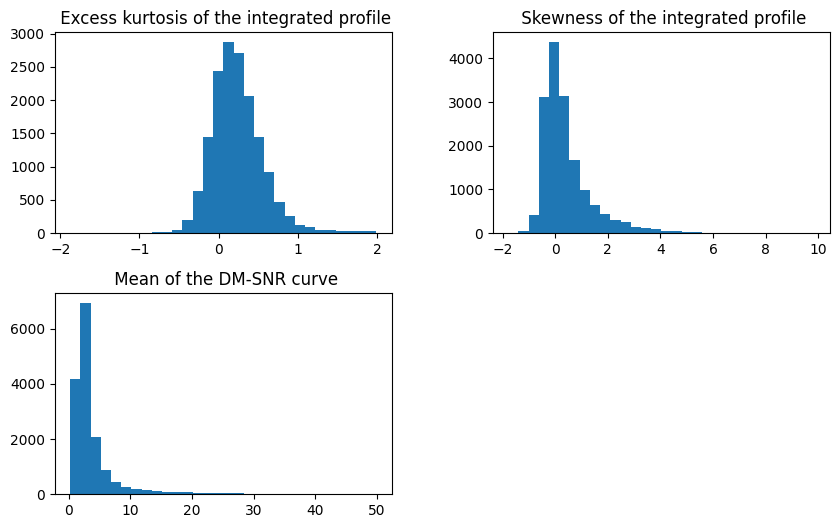

In [7]:
# 3개 컬럼 이상치 제거이후 분포확인
cols = df2.iloc[[0],[2,3,4]].columns
df2[(df2[cols[0]] < 2) & (df2[cols[1]] < 15) & (df2[cols[2]] < 50)][cols].hist(bins=30, figsize=(10,6), grid=False)
plt.show()

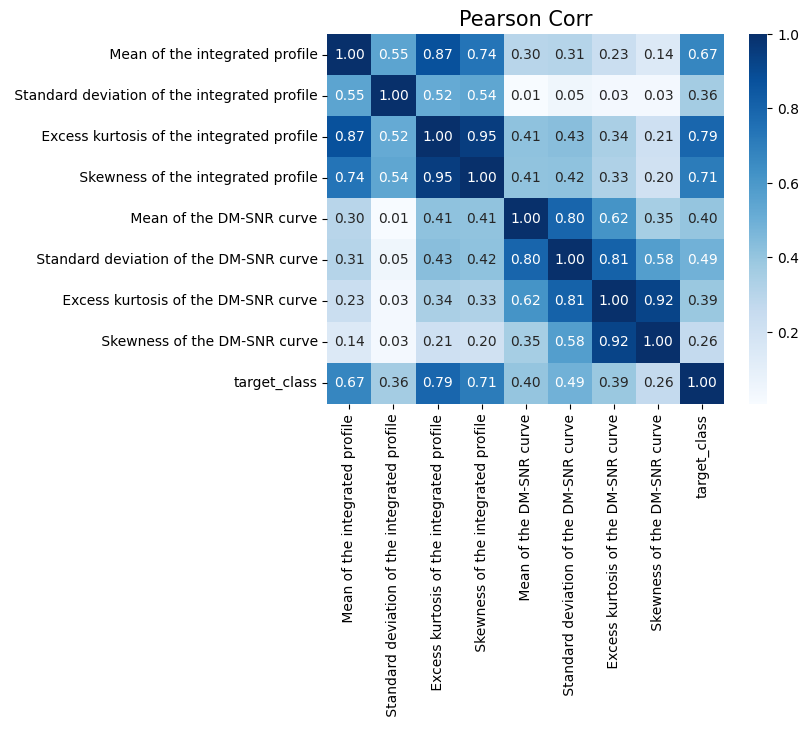

In [8]:
# 상관계수 확인
sns.heatmap(df2.corr().abs(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# (Skewness of the integrated profile, Excess kurtosis of the integrated profile)
# (Excess kurtosis of the DM-SNR curve, Skewness of the DM-SNR curve)가 상관계수 높음
# => 상관계수가 전체적으로 높진않다. 2개 feature를 드랍하거나 아니면 무시하고 진행가능할듯?

In [ ]:
(여기서부터 내용 추가)

동 데이터셋 관련 논문과 백서
* https://academic.oup.com/mnras/article/409/2/619/1037409
* https://www.escholar.manchester.ac.uk/api/datastream?publicationPid=uk-ac-man-scw:305203&datastreamId=FULL-TEXT.PDF

In [19]:
df2.describe()

# 컬럼별 데이터 값 범위 차이가 있어 표준화 필요

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


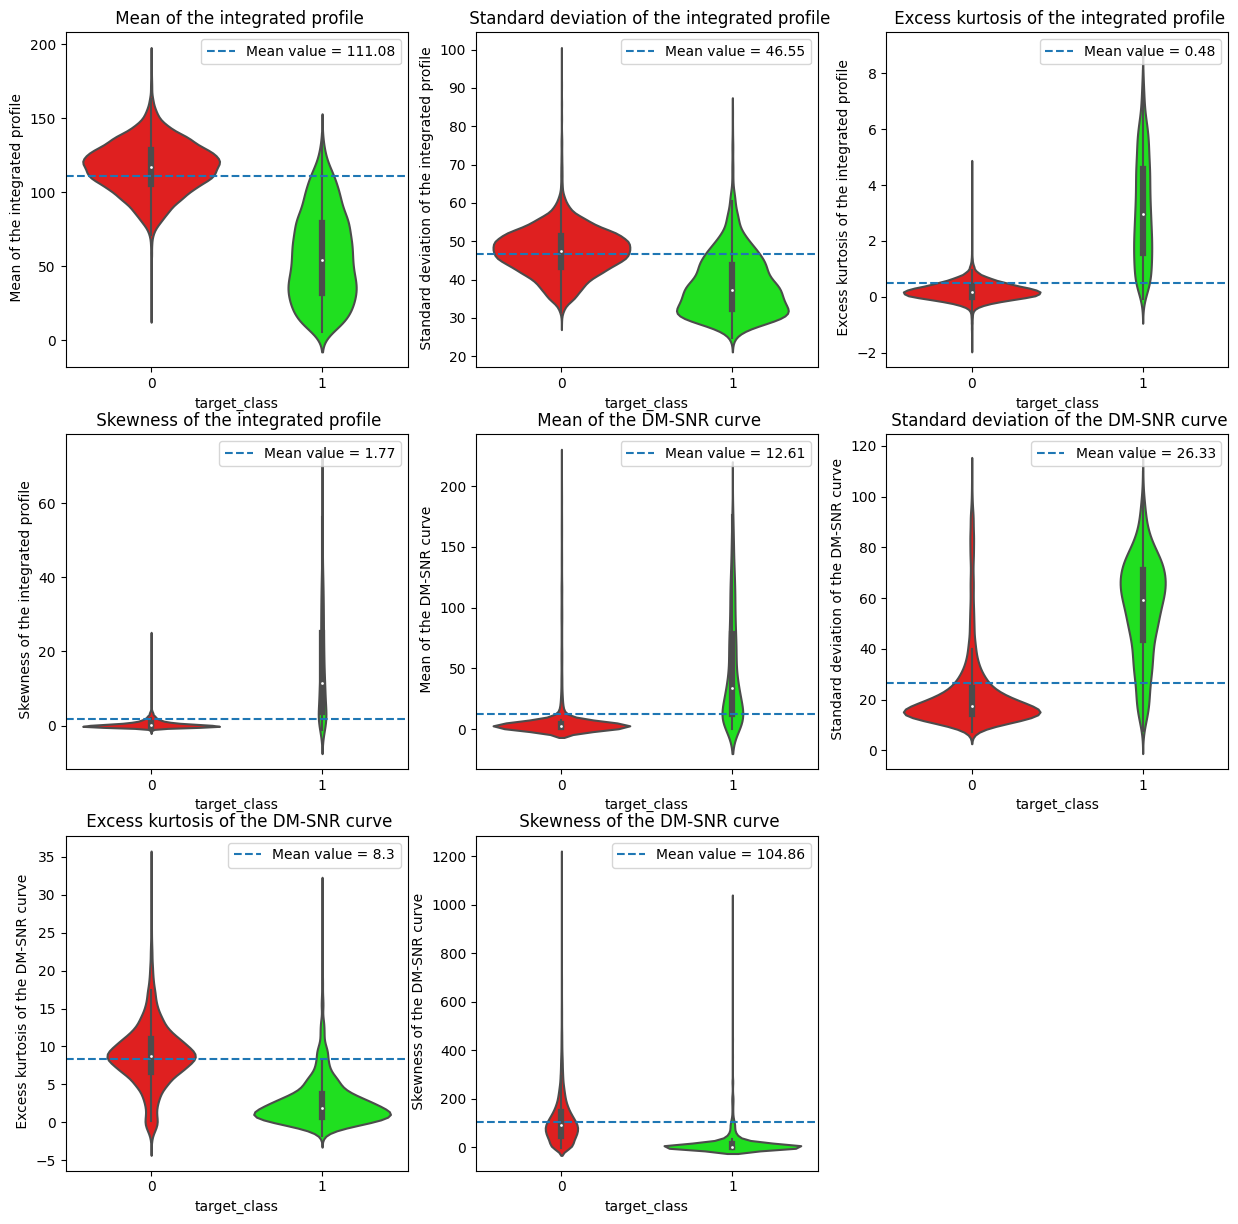

In [17]:
#바이올린 플롯
# mean_profile, kurtosis_profile, skewness_profile 컬럼을 보면 클래스 구분이 확실히 되는 것을 확인

features = df2.iloc[:,0:8]
plt.figure(figsize=(15,20))
j = 0
for i in features:
    plt.subplot(4,3,j+1)
    sns.violinplot(x=df2["target_class"],y=df2[i],palette=["red","lime"])
    plt.title(i)
    plt.axhline(df2[i].mean(),linestyle = "dashed", label ="Mean value = " + str(round(df2[i].mean(), 2)))
    plt.legend(loc="best")
    j = j + 1

## data3 (multi_classification_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

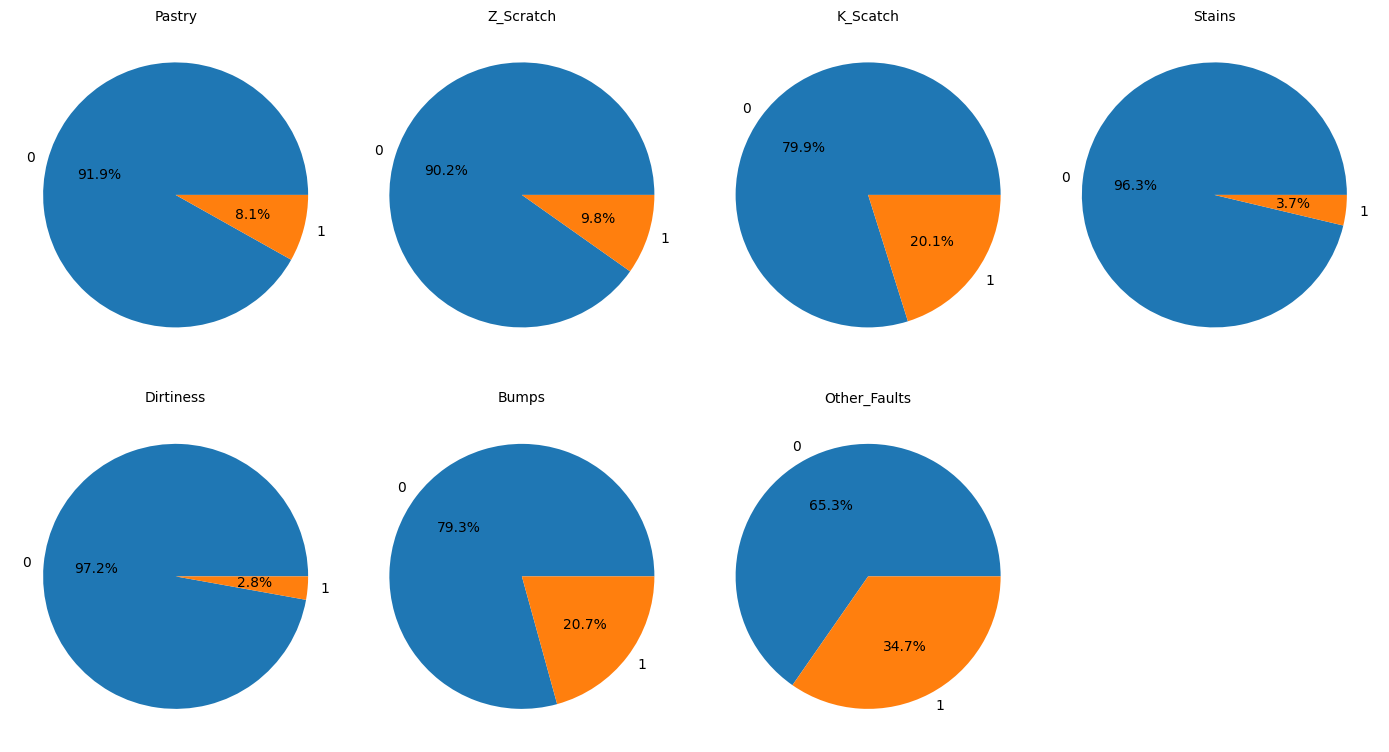

In [9]:
df3 = pd.read_csv('data/mulit_classification_data.csv')
df3.info()
print(f'\n 중복항 존재여부 : {df3.duplicated().any()}\n')

# 하자가 없는 row가 있는지 확인
print(f'하자없는 row : {df3.iloc[:,27:].apply(lambda row: not (row == 1).any(), axis=1).any()}')

print('target class 비율')
fig = plt.figure(figsize=(14,8))
x = 0
for i in df3.iloc[:,27:].columns:
    x += 1
    temp = df3[i].value_counts()
    ax = fig.add_subplot(240+x)
    ax.pie(temp, labels=[0,1], autopct='%1.1f%%')
    ax.set_title(i, fontsize=10)
plt.tight_layout()
plt.show()


# row 1941개
# 중복없음, 결측없음
# 독립변수중 범주형 3개
# target 7개이며, class 비율이 다채롭다. 2.8% 부터 34.7% 까지 존재
# 하자가 하나도 없는 row는 없다. 마찬가지로 하자는 하나씩만 존재한다.

# => 마찬가지로 Catboost, LigthGBM 고려 x
# 

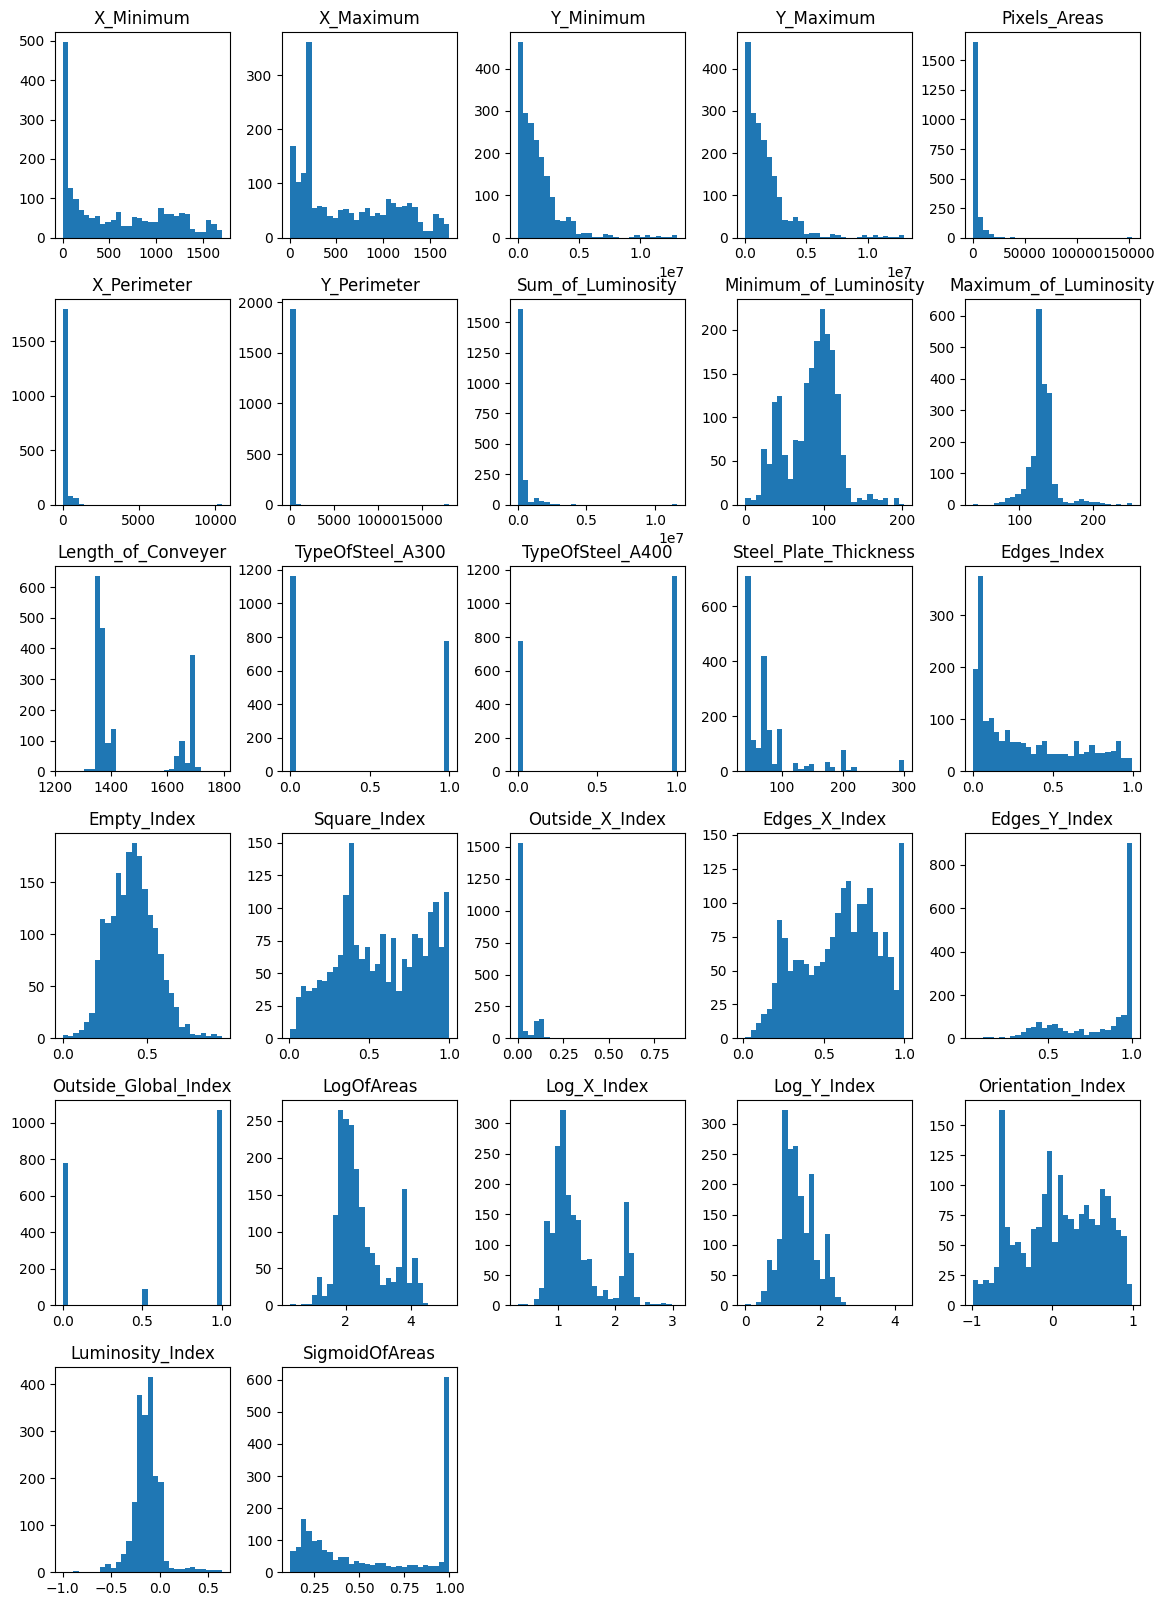

In [10]:
# 데이터 분포 확인
df3.iloc[:,:27].hist(bins=30, figsize=(14,20), grid=False)
plt.show()

# 전체적으로 skewed data가 많다.
# 범주형 데이터 : ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']
# Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity 아웃라이어 존재

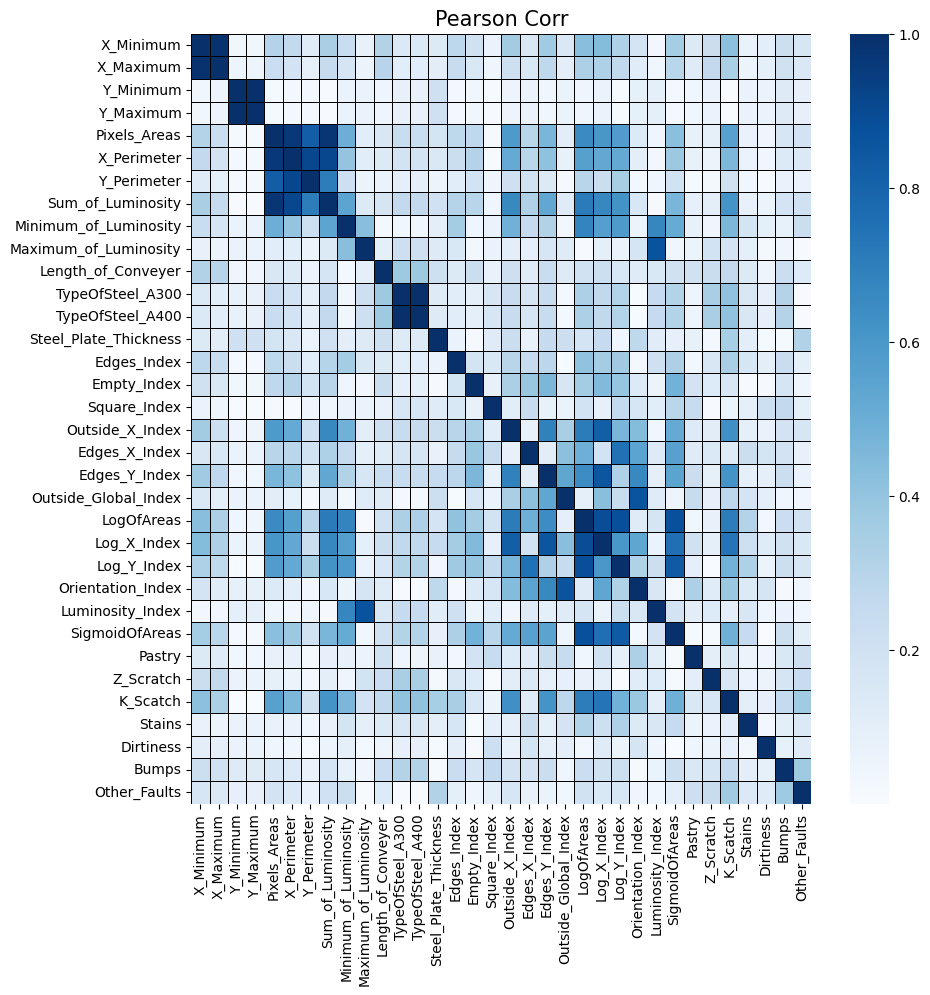

In [11]:
# 상관계수 확인
plt.figure(figsize=(10,10))
sns.heatmap(df3.corr().abs(), cmap='Blues', linewidths=0.4, linecolor='black')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# X, Y의 min max는 상관계수 1
# TypeOfSteel두개는 상관계수 1
# Pixels_Areas와 Sum_of_Luminosity의 상관계수도 0.97로 매우 높다.


In [ ]:
(여기서부터 내용 추가)

In [18]:
df3.describe()


# 결과를 보면 최소값과 최댓값의 차이가 나타나서, 이상치를 제거할 필요가 있음
# 컬럼별 값의 범위 차이가 꽤 큼 => 표준화 필요

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
